# Entrainment <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

In this notebook, we seek to determine the effect of entrainment on a descending parcel.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Converting-theory-to-code" data-toc-modified-id="Converting-theory-to-code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Converting theory to code</a></span><ul class="toc-item"><li><span><a href="#Step-1:-mixing-without-phase-change" data-toc-modified-id="Step-1:-mixing-without-phase-change-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Step 1: mixing without phase change</a></span></li><li><span><a href="#Step-2:-reaching-phase-equilibrium" data-toc-modified-id="Step-2:-reaching-phase-equilibrium-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Step 2: reaching phase equilibrium</a></span></li><li><span><a href="#Step-3:-descent" data-toc-modified-id="Step-3:-descent-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Step 3: descent</a></span></li></ul></li><li><span><a href="#Assembling-steps-1-3" data-toc-modified-id="Assembling-steps-1-3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assembling steps 1-3</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Dry-descent-vs.-entrainment-rate" data-toc-modified-id="Dry-descent-vs.-entrainment-rate-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dry descent vs. entrainment rate</a></span></li><li><span><a href="#Concerns-about-step-size" data-toc-modified-id="Concerns-about-step-size-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Concerns about step size</a></span></li><li><span><a href="#Moist-descent-vs.-entrainment-rate" data-toc-modified-id="Moist-descent-vs.-entrainment-rate-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Moist descent vs. entrainment rate</a></span></li></ul></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.constants as const
from metpy.units import units
from metpy.units import concatenate

from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

from os import mkdir
from os.path import exists
import sys

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, remaining_liquid_ratio, evaporation_level
from thermo import extra_liquid_descent_profile
from thermo import specific_humidity_from_descent_profile

In [480]:
fig_path = ('20210929_entrainment_figures/')
if not exists(fig_path):
    mkdir(fig_path)

In [141]:
file = '../../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
sydney = Environment(
    pressure, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

## Converting theory to code

We imagine a parcel, whose properties are denoted by a subscript P, and its environment, whose properties are denoted by a subscript E. As a result of descending through a distance $dz$, equal masses $dm$ of parcel and environmental air have been exchanged:
<img src='diagram1.png' style="width: 450px;">

The size of $dm$ is related to $dz$ by the *entrainment rate* $\lambda$, which is defined as the fraction of the parcel's mass that is exchanged per unit height:
$$ \lambda \equiv \frac{d\left(\frac{m}{m_P}\right)}{dz}. $$
Thus $dm = \lambda m_P dz$.
We now consider the parcel as a container with an imaginary partition between the original portion with mass $m_P - dm$ and the entrained portion with mass $dm$:
<img src='diagram2.png' style="width: 450px;">

The partition is then removed, and a three-step process occurs:
1. The two parts mix, conserving enthalpy and water mass without any phase changes,
2. The liquid and vapour phases of water come into equilibrium, with phase changes if necessary, and
3. The parcel descends a distance $dz$, either dry or moist adiabatically.

### Step 1: mixing without phase change
Enthalpy conservation requires that
$$
\begin{align}
    (m_P - dm) c_p T_P + dm~c_p T_E &= m_P c_p T' \\
    \Leftrightarrow \qquad T' &= \frac{(m_P - dm) c_p T_P + dm~c_p T_E}{m_P} \\
    &= T_P + \frac{dm}{m_P} (T_E - T_P) \\
    &= T_P + \lambda (T_E - T_P) dz.
\end{align}
$$
Conservation of water vapour mass (with no condensation) requires that
$$
\begin{align}
    m_{v,P} + m_{v,E} &= m_v' \\
    \Leftrightarrow \qquad (m - dm) q_P + dm~q_E &= m_P q' \\
    \Leftrightarrow \qquad q' &= q_P + \lambda (q_E - q_P) dz.
\end{align}
$$
If we use $l$ to denote a ratio of liquid mass to total mass, conservation of liquid water mass gives an identical relation
$$ l' = l_P + \lambda (l_E - l_P) dz. $$

In [1]:
def mix(parcel, environment, rate, dz):
    return parcel + rate * (environment - parcel) * dz

### Step 2: reaching phase equilibrium

Let us denote the saturation specific humidity at pressure $p$ and temperature $T$ by $q^*(p,T)$. We wish to find the final specific humidity $q''$, liquid ratio $l''$ and temperature $T''$ of the parcel once phase equilibrium is reached.

To start with, we know that any phase changes must conserve total water mass:
$$ q' + l' = q'' + l''.$$

We also know that the heat $dQ$ required to increase the specific humidity by $dq$ is given by
$$ \frac{dQ}{m} = -L~dq = L(q' - q'') = L(l'' - l'), $$
and if the process occurs at constant pressure, the corresponding change in temperature will be
$$
\begin{align}
    c_p~dT &= -L~dq \\
    \Leftrightarrow \qquad T'' &= T' + \frac{L(q' - q'')}{c_p} = T' + \frac{L(l'' - l')}{c_p}.
\end{align}
$$

**Case 1:** If $q' > q^*(p,T')$, water vapour must condense and the parcel will warm until it reaches a state where
$$
\begin{align}
    q'' &= q^*(p,T'') \\
    &= q^* \left(p, T' + \frac{L(q' - q'')}{c_p} \right),
\end{align}
$$
with $l'' = l' + q' - q''$.

**Case 2:** If $q' \le q^*(p,T')$ and $l' > 0$, liquid water must evaporate and the parcel will cool until either
- **Case 2.1:** all liquid has evaporated, i.e., $l'' = 0$ and 
$$
    q'' = q' + l' < q^*(p,T'') = q^* \left(p, T' - \frac{Ll'}{c_p} \right)
$$
    or
- **Case 2.2:** the parcel reaches saturation, i.e.,
$$
\begin{align}
    q'' &= q^*(p,T'') \\
    &= q^* \left(p, T' + \frac{L(q' - q'')}{c_p} \right),
\end{align}
$$
    with $l'' = l' + q' - q''$. This is identical to Case 1, except that here $q'' > q'$.
    
The equations for all cases can be solved numerically.

In [374]:
def temperature_change(dq):
    """Calculates the temperature change due to specific humidity change."""
    
    dt = -const.water_heat_vaporization * dq / const.dry_air_spec_heat_press
    return dt.to(units.delta_degC)

def q_root(q_final, pressure, t_initial, q_initial):
    """Input function for root-finding algorithm."""
    
    q_final = q_final*units.dimensionless
    t_final = t_initial + temperature_change(q_final - q_initial)
    q_final_saturated = mpcalc.specific_humidity_from_mixing_ratio(
        mpcalc.saturation_mixing_ratio(pressure, t_final))
    return (q_final - q_final_saturated).to(units.dimensionless).m

def equilibrate(
        pressure, t_parcel, q_parcel, l_parcel, t_env, q_env, l_env, rate, dz):
    """
    Finds parcel properties after entrainment and phase equilibration.
    
    Args:
        pressure: Pressure during the change (constant).
        t_parcel: Initial temperature of the parcel.
        q_parcel: Initial specific humidity of the parcel.
        l_parcel: Initial ratio of liquid mass to parcel mass.
        t_env: Temperature of the environment.
        q_env: Specific humidity of the environment.
        l_env: Liquid ratio of the environment.
        rate: Entrainment rate.
        dz: Distance descended.
        
    Returns:
        A tuple containing the final parcel temperature, specific
            humidity and liquid ratio.
    """
    
    # mixing without phase change
    t_mixed = mix(t_parcel, t_env, rate, dz)
    q_mixed = mix(q_parcel, q_env, rate, dz)
    l_mixed = mix(l_parcel, l_env, rate, dz)
    q_mixed_saturated = mpcalc.specific_humidity_from_mixing_ratio(
        mpcalc.saturation_mixing_ratio(pressure, t_mixed))
    
    if q_mixed > q_mixed_saturated:
        # we need to condense water vapour
        sol = root_scalar(
            q_root, args=(pressure, t_mixed, q_mixed), bracket=[0, q_mixed])
        q_final = sol.root
        t_final = t_mixed + temperature_change(q_final - q_mixed)
        l_final = l_mixed + q_mixed - q_final
        return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed > 0:
        # we need to evaporate liquid water.
        # if all liquid evaporates:
        t_all_evap = t_mixed + temperature_change(l_mixed)
        q_all_evap_saturated = mpcalc.specific_humidity_from_mixing_ratio(
            mpcalc.saturation_mixing_ratio(pressure, t_all_evap))
        
        if q_mixed + l_mixed <= q_all_evap_saturated:
            return (t_all_evap, q_mixed + l_mixed, 0*units.dimensionless)
        else:
            sol = root_scalar(
                q_root, args=(pressure, t_mixed, q_mixed),
                bracket=[q_mixed, q_mixed + l_mixed])
            q_final = sol.root
            t_final = t_mixed + temperature_change(q_final - q_mixed)
            l_final = l_mixed + q_mixed - q_final
            return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed <= 0:
        # already in equilibrium, no action needed
        return (t_mixed, q_mixed, 0*units.dimensionless)
    else:
        # parcel is perfectly saturated, no action needed
        return (t_mixed, q_mixed, l_mixed)

### Step 3: descent

Once the temperature, specific humidity and liquid content of the parcel after mixing are known, it is a relatively simple matter to use the functions of MetPy and those we have already written to determine how they change when the parcel descends a distance $dz$.

In [306]:
def descend(
        pressure, t_initial, q_initial, l_initial, reference_pressure=None):
    """
    Calculates parcel properties after descent.
    
    Args:
        pressure: Array of pressures at which to compute properties.
        t_initial: Initial temperature.
        q_initial: Initial specific humidity.
        l_initial: Initial liquid mass ratio.
        reference_pressure: Pressure corresponding to initial values.
            Defaults to pressure[0].
            
    Returns:
        A 3-tuple containing the final temperature, specific humidity
            and liquid ratio.
    """
    
    pressure = np.atleast_1d(pressure)
    if reference_pressure is None:
        refrence_pressure = pressure[0]
    
    if l_initial == 0:
        t_final = mpcalc.dry_lapse(
            pressure, t_initial, reference_pressure=reference_pressure)
        if pressure.size > 1:
            q_final = np.ones(pressure.size) * q_initial
            l_initial = np.zeros(pressure.size)*units.dimensionless
        else:
            t_final = t_final[0]
            q_final = q_initial
            l_final = 0*units.dimensionless
        return (t_final, q_final, l_final)
    else:
        level, level_temperature = evaporation_level(
            reference_pressure, t_initial, l_initial)
        t_final = extra_liquid_descent_profile(
            pressure, t_initial, level, level_temperature,
            reference_pressure=reference_pressure)
        q_final = specific_humidity_from_descent_profile(
            pressure, t_final, level, level_temperature)
        # use conservation of liquid mass to find l_final
        l_final = np.max(
            [0, q_initial + l_initial - q_final])*units.dimensionless
        return (t_final, q_final, l_final)

We will actually employ an approximation to speed up the calculation. If the distance descended $dz$ is small, we can assume that the descent is either entirely dry adiabatic or entirely moist adiabatic. We neglect the possibility that the liquid water in the parcel may evaporate completely halfway down, since this would not happen very often (making the exact calculation pointless in most cases) and the error introduced by the approximation should be negligible for small $dz$.

In [429]:
def descend_approx(
        pressure, t_initial, q_initial, l_initial, reference_pressure=None):
    """
    Calculates parcel properties after descent.
    
    Args:
        pressure: Array of pressures at which to compute properties.
        t_initial: Initial temperature.
        q_initial: Initial specific humidity.
        l_initial: Initial liquid mass ratio.
        reference_pressure: Pressure corresponding to initial values.
            Defaults to pressure[0].
            
    Returns:
        A 3-tuple containing the final temperature, specific humidity
            and liquid ratio.
    """
    
    pressure = np.atleast_1d(pressure)
    if reference_pressure is None:
        refrence_pressure = pressure[0]
    
    if l_initial <= 0:  # catch the erroneous l < 0 case
        t_final = mpcalc.dry_lapse(
            pressure, t_initial, reference_pressure=reference_pressure)
        if pressure.size > 1:
            q_final = np.ones(pressure.size) * q_initial
            l_initial = np.zeros(pressure.size)*units.dimensionless
        else:
            t_final = t_final[0]
            q_final = q_initial
            l_final = 0*units.dimensionless
        return (t_final, q_final, l_final)
    else:
        # assume that descent will be entirely moist adiabatic
        # any error will be small for small dz
        t_final = moist_lapse(
            pressure, t_initial, reference_pressure=reference_pressure)
        q_final = mpcalc.specific_humidity_from_mixing_ratio(
            mpcalc.saturation_mixing_ratio(pressure, t_final))
        if pressure.size == 1:
            q_final = q_final[0]
        # use conservation of liquid mass to find l_final
        l_final = np.max(
            [0, q_initial + l_initial - q_final])*units.dimensionless
        return (t_final, q_final, l_final)

We can see that the approximate method is more than 20 times faster!

In [376]:
q = mpcalc.specific_humidity_from_mixing_ratio(
            mpcalc.saturation_mixing_ratio(550*units.mbar, 0*units.celsius))

In [377]:
%%timeit
descend(550*units.mbar, 0*units.celsius, q, 2e-4, reference_pressure=549.5*units.mbar)

218 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [378]:
%%timeit
descend_approx(550*units.mbar, 0*units.celsius, q, 2e-4, reference_pressure=549.5*units.mbar)

9.83 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Assembling steps 1-3

We now combine the functions for the three steps. They are only valid for small, discrete steps $dz$, so the goal is to accurately find the derivatives $dT/dz$, $dq/dz$ and $dl/dz$ at any given height, so that we can integrate them numerically to find $T$, $q$ and $l$ at any height, with continuous entrainment.

We will use a first-order finite difference approximation:
$$\frac{dT}{dz} = \frac{T(z-dz) - T(z)}{-dz} + O(dz)$$
for small $dz$ (about 1 m).

In [426]:
def entrain_differential(
        height, state, pressure, t_env, q_env, l_env, rate, dz):
    """
    Finds the rate of change of parcel properties due to descent/entrainment.
    
    Args:
        height: Height of interest, in METRES, as number without units.
        state: Array containing parcel temperature in KELVIN,
            specific humidity and liquid ratio, all as numbers without
            units.
        pressure: Function to calculate pressure from height.
        t_env: Function giving environmental temperature from height.
        q_env: Function giving environmental specific humidity from
            height.
        l_env: Function giving environmental liquid ratio from height.
        rate: Entrainment rate.
        dz: Size of *downward* step, i.e. initial minus final height.
        
    Returns:
        3-tuple containing:
            Temperature change per unit height descended, in K/m
            Specific humidity change per unit height descended, in 1/m
            Liquid ratio change per unit height descended, in 1/m
    """
    
    height = height*units.meter
    t_parcel = state[0]*units.kelvin
    q_parcel = state[1]
    l_parcel = state[2]
    p_initial = pressure(height)
    p_final = pressure(height - dz)
    
    # steps 1 and 2: mixing and phase equilibration
    t_eq, q_eq, l_eq = equilibrate(
        p_initial, t_parcel, q_parcel, l_parcel, 
        t_env(height), q_env(height), l_env(height), rate, dz)
    
    # step 3: dry or moist adiabatic descent
    t_final, q_final, l_final = descend_approx(
        p_final, t_eq, q_eq, l_eq, reference_pressure=p_initial)
    
    # approximate derivatives using finite differences
    # divide by -dz to get actual rate of change with height
    dtdz = ((t_final.to(units.kelvin)
            - t_parcel.to(units.kelvin)) / -dz).to(units.kelvin/units.meter).m
    dqdz = ((q_final - q_parcel) / -dz).to(1/units.meter).m
    dldz = ((l_final - l_parcel) / -dz).to(1/units.meter).m
    
    return (dtdz, dqdz, dldz)

In [495]:
def entrainment_profile(
        height, t_initial, q_initial, l_initial, pressure,
        t_env, q_env, l_env, rate, dz, reference_height=None):
    """
    Calculates parcel properties for descent with entrainment.
    
    Args:
        height: Array of heights of interest.
        t_initial: Initial parcel temperature.
        q_initial: Initial parcel specific humidity.
        l_initial: Initial parcel liquid ratio.
        pressure: Function to calculate pressure from height.
        t_env: Function giving environmental temperature from height.
        q_env: Function giving environmental specific humidity from
            height.
        l_env: Function giving environmental liquid ratio from height.
        rate: Entrainment rate.
        dz: Size of *downward* step for computing finite differences.
        
    Returns:
        3-tuple containing the temperature, specific humidity and
            liquid ratio arrays for the given height array.
    """
    
    if reference_height is None:
        reference_height = height[0]
    t_initial = t_initial.to(units.kelvin).m

    sol = solve_ivp(
        entrain_differential,
        (reference_height.to(units.meter).m, height[-1].to(units.meter).m),
        (t_initial, q_initial, l_initial),
        args=(pressure, t_env, q_env, l_env, rate, dz),
        t_eval=height.to(units.meter).m)
    
    t_out = sol.y[0,:]*units.kelvin
    q_out = sol.y[1,:]*units.dimensionless
    l_out = sol.y[2,:]*units.dimensionless
    
    if height.size == 1:
        t_out = t_out.item()
        q_out = q_out.item()
        l_out = l_out.item()
        
    return (t_out, q_out, l_out)

## Testing
### Dry descent vs. entrainment rate

We now test the functions on a parcel that is initially drier than the environment and contains no liquid water.

In [475]:
height = np.arange(5000, 2999, -100)*units.meter

In [476]:
sydney.temperature(height)

Magnitude,[-7.652863428873554 -6.815883883624487 -5.971540423115684 -5.119263440143849 -4.261792866525695 -3.45457146534876 -2.639525505856333 -1.8266920310368042 -1.0416813249039398 -0.248892726381992 0.551794104779137 1.371710519211956 2.21394965114517 2.864588308778628 3.2482147166824653 3.635723458467214 4.027157795211194 4.422558965719355 4.8461289916989925 5.693374968950946 6.5186753086607885]
Units,degree_Celsius


In [477]:
sydney.specific_humidity(height)

Magnitude,[0.0009755878698256892 0.0007334850874408808 0.0005462326898177255 0.00040241757532981804 0.00029793862372209126 0.0003047029271457488 0.00031170124720857756 0.0003187952079965115 0.00032560501421758585 0.00033264548582242717 0.0003399256706145801 0.0004062664681545181 0.0005859220460623755 0.0006676126791760811 0.0006299030651258274 0.0005939382183800407 0.0005596560822535501 0.0005269963629140958 0.0004993832970654975 0.0005338928619989044 0.0004912653504342183]
Units,dimensionless


In [496]:
# %%timeit
t1_dry_bigstep, q1_dry_bigstep, l1_dry_bigstep = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0/units.km, 1*units.m)
t2_dry_bigstep, q2_dry_bigstep, l2_dry_bigstep = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0.5/units.km, 1*units.m)
t3_dry_bigstep, q3_dry_bigstep, l3_dry_bigstep = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 1/units.km, 1*units.m)

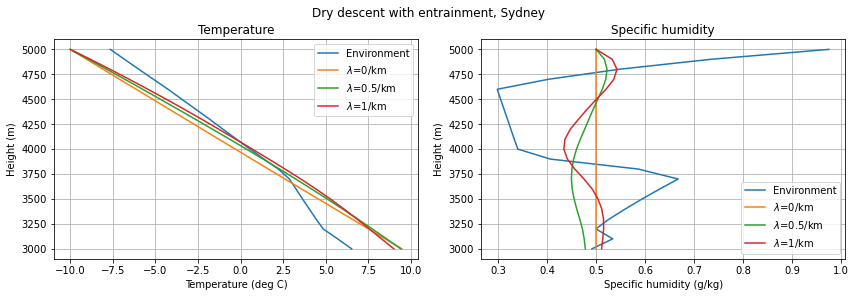

In [497]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1_dry_bigstep, height, label=r'$\lambda$=0/km')
ax.plot(t2_dry_bigstep, height, label=r'$\lambda$=0.5/km')
ax.plot(t3_dry_bigstep, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(122)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1_dry_bigstep*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2_dry_bigstep*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3_dry_bigstep*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

fig.tight_layout()
fig.suptitle('Dry descent with entrainment, Sydney', y=1.02)
# fig.savefig(
#     fig_path + 'dry_vs_entrainment_rate.png', dpi=300, facecolor='w',
#     bbox_inches='tight')
plt.show()

- The higher the entrainment rate, the more strongly the parcel is attracted to the environmental profile and the sooner it reaches equilibrium.

### Concerns about step size
If we restrict the ODE solver to 10 m steps (which many times slower), there is a change on the order of 10 mg/kg or a few percent in the calculated specific humidity. Should we be concerned?

In [493]:
# %%timeit
t1_dry, q1_dry, l1_dry = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0/units.km, 1*units.m)
t2_dry, q2_dry, l2_dry = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0.5/units.km, 1*units.m)
t3_dry, q3_dry, l3_dry = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 1/units.km, 1*units.m)

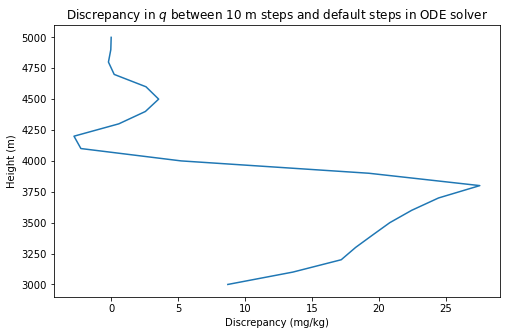

In [502]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot((q3_dry_bigstep - q3_dry)*1e6, height)
ax.set(
    xlabel='Discrepancy (mg/kg)',
    ylabel='Height (m)',
    title=r'Discrepancy in $q$ between 10 m steps and default steps in ODE solver')
plt.show()

In [505]:
np.abs(q3_dry_bigstep - q3_dry)/q3_dry*100

Magnitude,[0.0 0.0053100668845778515 0.03776330999099787 0.042046984801372804 0.5024235096497366 0.7135654425665358 0.5334442166543293 0.12301443752716383 0.6173165886384929 0.5160653446463115 1.218804577419109 4.562738268942961 6.423904891654026 5.425860610806512 4.781209919757228 4.308860272421936 3.9701150273054027 3.6766050639305194 3.45001313116816 2.7148090322852996 1.7346752631914621]
Units,dimensionless


### Moist descent vs. entrainment rate

We now try a parcel that is saturated and contains liquid water. This is SLOW because it requires a large amount of iteration.

In [486]:
height = np.arange(5000, 2999, -100)*units.meter
t_initial = -10*units.celsius

q_initial = mpcalc.specific_humidity_from_mixing_ratio(
    mpcalc.saturation_mixing_ratio(sydney.pressure(height[0]), t_initial))
l_initial = 1e-3

In [515]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0/units.km, 1*units.m)
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 0.5/units.km, 1*units.m)
t3, q3, l3 = entrainment_profile(
    height, t_initial, q_initial, l_initial,
    sydney.pressure, sydney.temperature, sydney.specific_humidity,
    lambda x: 0, 1/units.km, 1*units.m)

CPU times: user 2min 41s, sys: 370 ms, total: 2min 41s
Wall time: 2min 42s


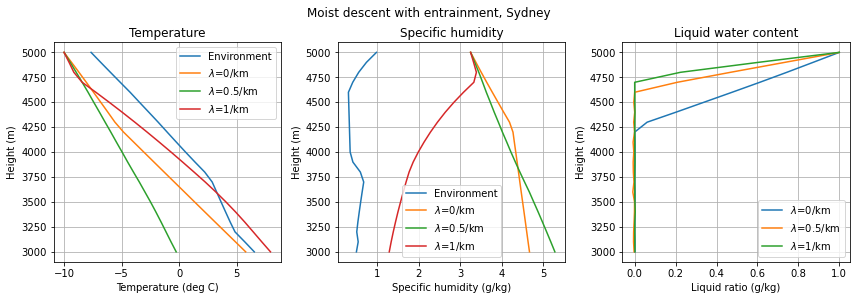

In [516]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1, height, label=r'$\lambda$=0/km')
ax.plot(t2, height, label=r'$\lambda$=0.5/km')
ax.plot(t3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(132)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

ax = fig.add_subplot(133)
ax.plot(l1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(l2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(l3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Liquid ratio (g/kg)',
    ylabel='Height (m)',
    title='Liquid water content')

fig.tight_layout()
fig.suptitle('Moist descent with entrainment, Sydney', y=1.03)
fig.savefig(
    fig_path + 'moist_vs_entrainment_rate.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

What is going on with $\lambda = 0.5$? $dT/dz$ and $dq/dz$ getting stuck on one value?

- Starting from the right, the liquid in the non-entraining parcel only evaporates due to warming from adiabatic compression.
- Liquid evaporates faster in the parcels that do entrain, due to the addition of subsaturated air.
- Due to the higher rate of evaporation, the temperature of a parcel with a higher entrainment rate initially increases slower as it descends.
- Once the liquid has completely evaporated, a parcel with a higher entrainment rate is again more strongly attracted to the environmental profile.
- The specific humidity of all the parcels initially increases due to evaporation. The rate of increase is slightly smaller for the entraining parcels due to mixing with the dry environment. Once all liquid has evaporated, the specific humidity decreases towards the environmental profile.


- A parcel that is evaporating liquid water due to entrainment will initially be more negatively buoyant, but once the liquid has evaporated, the stronger mixing will bring it into equilibrium with the environment sooner.

## Next steps

- Try to solve this equation analytically so that slow numerical solving is not needed:
$$q'' = q^* \left(p, T' + \frac{L(q' - q'')}{c_p} \right)$$

- Explore ways to improve accuracy without significant computational cost
    - Use second-order finite difference approximations for $dT/dz$, $dq/dz$ and $dl/dz$?
    $$ \frac{dT}{dz} = \frac{-T(z-2dz) + 4T(z-dz) - 3T(z)}{-2dz} + O(dz^2)$$
        The issue is that we do not know $T$ exactly as a function of $z$, so $T(z-dz)$ and $T(z-2dz)$ are
        themselves approximations, the latter being worse.
        
- Knowing temperature as a function of height, calculate buoyancy and solve equation of motion (relatively simple)